In [28]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)


Using device: mps


In [30]:
df = pd.read_csv("cleaned_dataset.csv")
print(df.head())
print(df["Has_Shift"].value_counts())

     image_path Midline_Shift  Surgery_Advisable    processed_image_path  \
0  images/1.jpg           NaN                  1  processed_images/1.jpg   
1  images/2.jpg           NaN                  0  processed_images/2.jpg   
2  images/3.jpg           NaN                  0  processed_images/3.jpg   
3  images/4.jpg         Right                  1  processed_images/4.jpg   
4  images/5.jpg           NaN                  0  processed_images/5.jpg   

   Has_Shift  Midline_Shift_Label  
0          0                    2  
1          0                    2  
2          0                    2  
3          1                    1  
4          0                    2  
Has_Shift
1    621
0    365
Name: count, dtype: int64


In [31]:
class BrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "processed_image_path"]
        label = int(self.df.loc[idx, "Has_Shift"])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

In [32]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["Has_Shift"], random_state=42)


In [33]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

In [34]:
train_dataset = BrainDataset(train_df, transform=train_transform)
test_dataset = BrainDataset(test_df, transform=test_transform)

In [35]:
class_counts = df["Has_Shift"].value_counts().sort_index()
neg, pos = class_counts[0], class_counts[1]
inv_class_freq = {0: 1.0 / neg, 1: 1.0 / pos}
sample_weights = [inv_class_freq[int(l)] for l in train_df["Has_Shift"]]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [36]:
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [37]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_features, 1)
)

model = model.to(device)

In [38]:
pos_weight = torch.tensor([1.3 * (neg / pos)], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)

In [39]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 0.5653
Epoch [2/20], Loss: 0.4743
Epoch [3/20], Loss: 0.3707
Epoch [4/20], Loss: 0.3111
Epoch [5/20], Loss: 0.2868
Epoch [6/20], Loss: 0.2851
Epoch [7/20], Loss: 0.2032
Epoch [8/20], Loss: 0.2014
Epoch [9/20], Loss: 0.1866
Epoch [10/20], Loss: 0.1927
Epoch [11/20], Loss: 0.1647
Epoch [12/20], Loss: 0.1565
Epoch [13/20], Loss: 0.1426
Epoch [14/20], Loss: 0.1046
Epoch [15/20], Loss: 0.1285
Epoch [16/20], Loss: 0.1443
Epoch [17/20], Loss: 0.1166
Epoch [18/20], Loss: 0.1150
Epoch [19/20], Loss: 0.0901
Epoch [20/20], Loss: 0.1066



=== Evaluation Results (EfficientNet-B0) ===
Accuracy : 0.7576
Precision: 0.8889
Recall   : 0.7040
F1 Score : 0.7857

Classification Report:

              precision    recall  f1-score   support

    No Shift       0.63      0.85      0.72        73
       Shift       0.89      0.70      0.79       125

    accuracy                           0.76       198
   macro avg       0.76      0.78      0.75       198
weighted avg       0.79      0.76      0.76       198



/var/folders/h8/6p4k9gpj52g9xjrh452vpgh80000gn/T/ipykernel_18999/132475465.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_true = [int(x) for x in y_true]
/var/folders/h8/6p4k9gpj52g9xjrh452vpgh80000gn/T/ipykernel_18999/132475465.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred = [int(x) for x in y_pred]


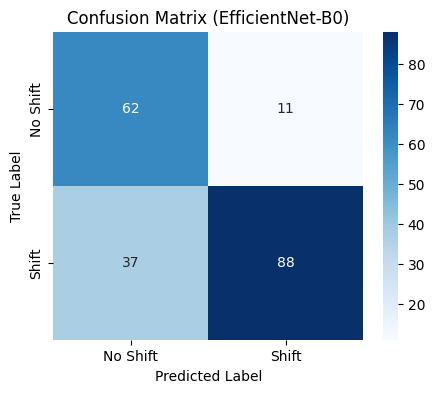

In [40]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.unsqueeze(1).to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = [int(x) for x in y_true]
y_pred = [int(x) for x in y_pred]

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

print("\n=== Evaluation Results (EfficientNet-B0) ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["No Shift", "Shift"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Shift", "Shift"],
            yticklabels=["No Shift", "Shift"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (EfficientNet-B0)")
plt.show()


In [41]:
torch.save(model.state_dict(), "midline_shift_model_efficientB0.pth")